In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 34.0MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


In [26]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [4]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [7]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [13]:
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
from os import getcwd

classes = ["kangaroo", "raccoon"]
wd = "."
annotation_path = "cvdl_final_train.txt"
list_file = open(annotation_path, 'w')

for obj_class in classes:
    obj_class_path = 'cvdl_final_images/%s/'%(obj_class)
    print("obj_class_path:", obj_class_path)
    for filename in os.listdir(obj_class_path):
      if filename.endswith('.xml'):
        in_file = open(obj_class_path + '/' + filename)
        tree = ET.parse(in_file)
        root = tree.getroot()
        list_file.write('%s/cvdl_final_images/%s/%s'%(wd, obj_class, root.find("filename").text))
        for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
        list_file.write('\n')

list_file.close()

obj_class_path: cvdl_final_images/kangaroo/
obj_class_path: cvdl_final_images/raccoon/


In [29]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # Python PIL “IOError: image file truncated” with big images: https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images

# annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/cvdl_final_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [16]:


input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 328 samples, val on 36 samples, with batch size 16.
Epoch 1/50
20/20 [==============================] - 55s 3s/step - loss: 3733.4892 - val_loss: 1056.5534

Epoch 2/50
20/20 [==============================] - 24s 1s/step - loss: 558.5719 - val_loss: 302.0626
Epoch 3/50
20/20 [==============================] - 25s 1s/step - loss: 242.7508 - val_loss: 178.4489
Epoch 4/50
20/20 [==============================] - 12s 610ms/step - loss: 168.9883 - val_loss: 139.9755
Epoch 5/50
20/20 [==============================] - 25s 1s/step - loss: 135.7405 - val_loss: 119.1382
Epoch 6/50
20/20 [==============================] - 24s 1s/step - loss: 109.5739 - val_loss: 94.5210
Epoch 7/50
20/20 [==============================] - 24s 1s/step - loss: 94.9034 - val_loss: 82.5764
Epoch 8/50
20/20 [==============================] - 24s 1s/step - loss: 83.8517 - val_loss: 72.4107
Epoch 9/50
20/20 [==============

In [10]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)













logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (151, 23) (219, 157)
kangaroo 0.74 (81, 15) (149, 163)
0.0803672510000979


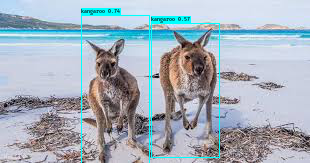

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 48) (166, 216)
0.08284796699990693


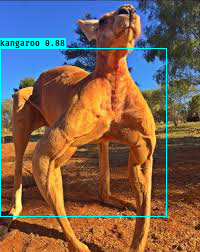

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (75, 49) (147, 147)
0.08027436700012913


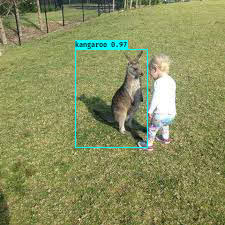

(416, 416, 3)
Found 2 boxes for img
raccoon 0.47 (40, 27) (147, 258)
kangaroo 0.75 (32, 19) (158, 251)
0.06648350000023129


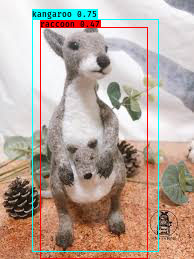

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.75 (101, 112) (170, 214)
kangaroo 0.91 (34, 63) (113, 151)
0.07394928900021114


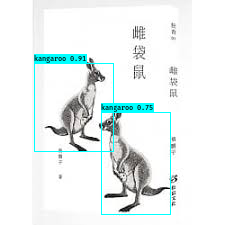

(416, 416, 3)
Found 2 boxes for img
raccoon 1.00 (143, 1) (300, 168)
kangaroo 0.98 (4, 18) (129, 168)
0.0595595830000093


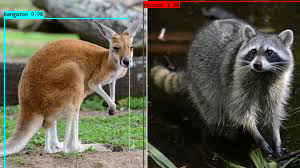

(416, 416, 3)
Found 2 boxes for img
raccoon 0.97 (159, 0) (302, 151)
kangaroo 0.91 (12, 4) (144, 106)
0.058997542999804864


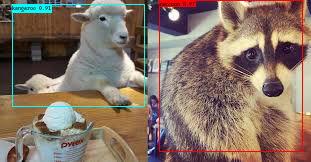

(416, 416, 3)
Found 2 boxes for img
raccoon 0.94 (0, 12) (154, 140)
raccoon 0.99 (155, 7) (290, 156)
0.06574899399993228


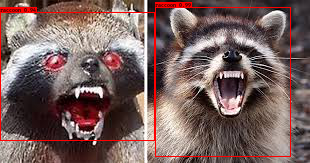

(416, 416, 3)
Found 0 boxes for img
0.057231178999700205


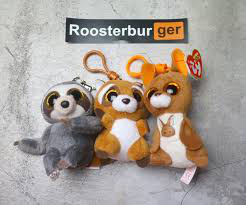

(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (90, 37) (162, 135)
raccoon 0.45 (168, 27) (269, 129)
0.05759316600006059


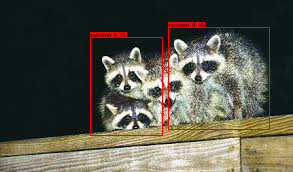

(416, 416, 3)
Found 0 boxes for img
0.05196952899996177


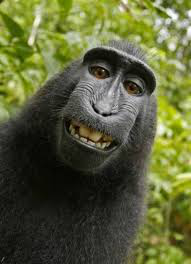

(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (49, 0) (199, 194)
0.05364820500017231


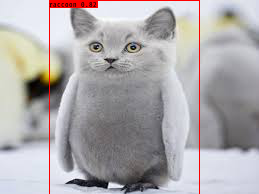

(416, 416, 3)
Found 0 boxes for img
0.05173414799992315


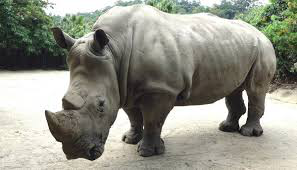

(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (14, 0) (285, 168)
0.05160253099984402


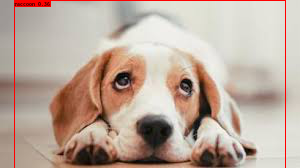

(416, 416, 3)
Found 2 boxes for img
raccoon 0.68 (168, 3) (238, 156)
kangaroo 0.99 (6, 62) (151, 159)
0.05637034000028507


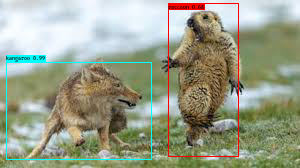

In [28]:
detect_path = '/content/gdrive/My Drive/keras-yolo3/cvdl_final_images/detect'
for filename in os.listdir(detect_path):
  image = Image.open('%s/%s'%(detect_path, filename)) 
  r_image = yolo_model.detect_image(image)
  display(r_image)